# Loan Dataset

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score, f1_score, fbeta_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, recall_score, f1_score, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import joblib
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from pandas.plotting import parallel_coordinates
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import OrdinalEncoder


## read the data

In [2]:
df=pd.read_csv("loan-10k.lrn.csv")
df_test = pd.read_csv("loan-10k.tes.csv")

## Explore the data

In [3]:
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 92 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          10000 non-null  int64  
 1   loan_amnt                   10000 non-null  float64
 2   funded_amnt                 10000 non-null  float64
 3   funded_amnt_inv             10000 non-null  float64
 4   term                        10000 non-null  object 
 5   int_rate                    10000 non-null  float64
 6   installment                 10000 non-null  float64
 7   emp_length                  10000 non-null  object 
 8   home_ownership              10000 non-null  object 
 9   annual_inc                  10000 non-null  float64
 10  verification_status         10000 non-null  object 
 11  loan_status                 10000 non-null  object 
 12  pymnt_plan                  10000 non-null  object 
 13  purpose                     1000

In [4]:
obj_cols = df.select_dtypes(include=['object'])
for col in obj_cols:
     print(col, "\n", obj_cols[col].head(), "\n")
     print(col)


term 
 0     36 months
1     60 months
2     60 months
3     36 months
4     36 months
Name: term, dtype: object 

term
emp_length 
 0    < 1 year
1      1 year
2    < 1 year
3     9 years
4      1 year
Name: emp_length, dtype: object 

emp_length
home_ownership 
 0    MORTGAGE
1    MORTGAGE
2        RENT
3        RENT
4    MORTGAGE
Name: home_ownership, dtype: object 

home_ownership
verification_status 
 0       Not Verified
1    Source Verified
2       Not Verified
3    Source Verified
4    Source Verified
Name: verification_status, dtype: object 

verification_status
loan_status 
 0        Current
1        Current
2     Fully Paid
3    Charged Off
4        Current
Name: loan_status, dtype: object 

loan_status
pymnt_plan 
 0    n
1    n
2    n
3    n
4    n
Name: pymnt_plan, dtype: object 

pymnt_plan
purpose 
 0    debt_consolidation
1    debt_consolidation
2    debt_consolidation
3    debt_consolidation
4    debt_consolidation
Name: purpose, dtype: object 

purpose
addr_state 
 0

## Statistical analysis of columns of type int and float 

In [5]:
numeric_columns = df.select_dtypes(include=np.number).drop("ID", axis=1)

# calculate statistics for each numeric column
stats_list = []
for col in numeric_columns:
    stats_dict = {
        "Column": col,
        "Mean": df[col].mean(),
        "Median": df[col].median(),
        "Standard Deviation": df[col].std(),
       # "25th Percentile": np.percentile(df[col], 25),
       # "50th Percentile (Median)": np.percentile(df[col], 50),
       # "75th Percentile": np.percentile(df[col], 75)
    }
    stats_list.append(stats_dict)

# convert list of dictionaries to pandas DataFrame
stats_df = pd.DataFrame(stats_list)
stats_df

,Column,Mean,Median,Standard Deviation
0,loan_amnt,15631.152500,14000.00,9314.246117
1,funded_amnt,15631.152500,14000.00,9314.246117
2,funded_amnt_inv,15625.992500,14000.00,9312.426843
3,int_rate,13.216959,12.73,4.855838
4,installment,461.084183,396.78,269.903751
...,...,...,...,...
72,earliest_cr_line_year,2000.017900,2001.00,7.302583
73,last_pymnt_d_month,4.003000,2.00,3.224257
74,last_pymnt_d_year,2017.747300,2018.00,1.463235
75,last_credit_pull_d_month,3.334200,2.00,2.909666


## Change encoding of cells containing type object and calculate stats

In [6]:
changed_columns=[]

In [7]:
### term can be encoded either as a number or as binary. I chose number for now.
# candidate for binary encoding
print(df["term"].unique())
df["term"] = df["term"].str.extract('(\d+)').astype(int)
print(df["term"].unique())
changed_columns.append("term")


[' 36 months' ' 60 months']
[36 60]


In [8]:
df_test["term"] = df_test["term"].str.extract('(\d+)').astype(int)


### one-hot encoding & the proportion of 1s to 0s for each column within what was a single variable

#### emp length

In [9]:
print(df["emp_length"].unique())
emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df['emp_length'] = df['emp_length'].map(emp_length_map)
print(df['emp_length'])
changed_columns.append("emp_length")

['< 1 year' '1 year' '9 years' '10+ years' '3 years' '4 years' '7 years'
 '2 years' '5 years' '6 years' '8 years']
0        0
1        1
2        0
3        9
4        1
        ..
9995     5
9996    10
9997     0
9998     1
9999    10
Name: emp_length, Length: 10000, dtype: int64


In [10]:
print(df_test["emp_length"].unique())
emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10
}

df_test['emp_length'] = df_test['emp_length'].map(emp_length_map)
print(df_test['emp_length'])

['< 1 year' '10+ years' '6 years' '2 years' '3 years' '7 years' '4 years'
 '1 year' '8 years' '5 years' '9 years']
0        0
1       10
2        0
3       10
4        6
        ..
9995     6
9996     3
9997     4
9998     5
9999     3
Name: emp_length, Length: 10000, dtype: int64


#### home_ownership 

In [11]:
print(df["home_ownership"].unique())
df = pd.get_dummies(df, columns=["home_ownership"], prefix=["home"])
home_cols = df.filter(regex='^home').columns.tolist()
for col in home_cols:
    changed_columns.append(col)


['MORTGAGE' 'RENT' 'OWN' 'ANY' 'OTHER']


In [12]:
print(df_test["home_ownership"].unique())
df_test = pd.get_dummies(df_test, columns=["home_ownership"], prefix=["home"])
home_cols_t = df_test.filter(regex='^home').columns.tolist()

['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE']


#### loan_status

In [13]:
print(df["loan_status"].unique())
df = pd.get_dummies(df, columns=["loan_status"], prefix=["loan"])
loan_cols = df.filter(regex='^loan').columns.tolist()
for col in loan_cols:
    changed_columns.append(col)

['Current' 'Fully Paid' 'Charged Off' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)']


In [14]:
print(df_test["loan_status"].unique())
df_test = pd.get_dummies(df_test, columns=["loan_status"], prefix=["loan"])
loan_cols_t = df_test.filter(regex='^loan').columns.tolist()


['Current' 'Fully Paid' 'Charged Off' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)' 'Default']


#### purpose

In [15]:
print(df["purpose"].unique())
df = pd.get_dummies(df, columns=["purpose"], prefix="purpose")
#one-hot
purpose_cols = df.filter(regex='^purpose').columns.tolist()
for col in purpose_cols:
    changed_columns.append(col)

['debt_consolidation' 'car' 'credit_card' 'other' 'major_purchase'
 'home_improvement' 'small_business' 'medical' 'vacation' 'moving' 'house'
 'renewable_energy' 'wedding']


In [16]:
print(df_test["purpose"].unique())
df_test = pd.get_dummies(df_test, columns=["purpose"], prefix="purpose")
#one-hot
purpose_cols_t = df_test.filter(regex='^purpose').columns.tolist()

['home_improvement' 'debt_consolidation' 'other' 'medical'
 'major_purchase' 'house' 'credit_card' 'moving' 'vacation'
 'small_business' 'renewable_energy' 'car' 'wedding']


#### Addr_state

In [17]:
print(df["addr_state"].unique())
df = pd.get_dummies(df, columns=["addr_state"], prefix="addr")
#one-hot
addr_cols = df.filter(regex='^addr').columns.tolist()
for col in addr_cols:
    changed_columns.append(col)

['IL' 'OK' 'AZ' 'CA' 'FL' 'TX' 'PA' 'MA' 'NC' 'NV' 'SC' 'GA' 'NY' 'OR'
 'AL' 'VT' 'MD' 'KY' 'CO' 'IN' 'LA' 'MN' 'MI' 'WA' 'NJ' 'VA' 'WI' 'OH'
 'TN' 'CT' 'DC' 'HI' 'MO' 'DE' 'AR' 'KS' 'ME' 'MS' 'NM' 'AK' 'UT' 'WV'
 'MT' 'NH' 'SD' 'ID' 'NE' 'WY' 'ND' 'RI']


In [18]:
print(df_test["addr_state"].unique())
df_test = pd.get_dummies(df_test, columns=["addr_state"], prefix="addr")
addr_cols_t = df_test.filter(regex='^addr').columns.tolist()

['TX' 'OK' 'FL' 'MA' 'CO' 'PA' 'VA' 'NC' 'NJ' 'NY' 'CA' 'MS' 'IL' 'MD'
 'DE' 'DC' 'NM' 'MI' 'AR' 'MO' 'WI' 'NV' 'WA' 'SC' 'IN' 'UT' 'CT' 'AZ'
 'NH' 'RI' 'AL' 'MN' 'LA' 'OR' 'KS' 'OH' 'KY' 'TN' 'GA' 'ND' 'WY' 'ME'
 'MT' 'WV' 'AK' 'NE' 'SD' 'HI' 'ID' 'VT']


#### verification_status

In [19]:
print(df["verification_status"].unique())
df = pd.get_dummies(df, columns=["verification_status"], prefix="verif")
verif_cols = df.filter(regex='^verif').columns.tolist()
for col in verif_cols:
    changed_columns.append(col)

['Not Verified' 'Source Verified' 'Verified']


#### Stats of the one-hot encoded variables

In [20]:
print(df_test["verification_status"].unique())
df_test = pd.get_dummies(df_test, columns=["verification_status"], prefix="verif")
verif_cols_t = df_test.filter(regex='^verif').columns.tolist()

['Not Verified' 'Source Verified' 'Verified']


In [21]:
stats = df[changed_columns].describe()
stats

,term,emp_length,loan_amnt
count,10000.000000,10000.000000,10000.000000
mean,43.360800,5.967600,15631.152500
std,11.067523,3.692386,9314.246117
min,36.000000,0.000000,1000.000000
25%,36.000000,2.000000,8350.000000
50%,36.000000,6.000000,14000.000000
75%,60.000000,10.000000,21000.000000
max,60.000000,10.000000,40000.000000


### Binary encoding

In [22]:
le = LabelEncoder()

#### pymnt_plan

In [23]:
df['pymnt_plan'] = le.fit_transform(df['pymnt_plan'])
print(le.classes_)
print(df["pymnt_plan"].unique())

#turn n/y to binary
# n=0, y=1

['n' 'y']
[0 1]


In [24]:
df_test['pymnt_plan'] = le.fit_transform(df_test['pymnt_plan'])
print(le.classes_)
print(df["pymnt_plan"].unique())

['n' 'y']
[0 1]


#### initial_list_status

In [25]:
df['initial_list_status'] = le.fit_transform(df['initial_list_status'])
print(le.classes_)
print(df["initial_list_status"].unique())
#w/f to binary
#f=0, w=1

['f' 'w']
[1 0]


In [26]:
df_test['initial_list_status'] = le.fit_transform(df_test['initial_list_status'])
print(le.classes_)
print(df_test["initial_list_status"].unique())
#w/f to binary
#f=0, w=1

['f' 'w']
[1 0]


#### application_type

In [27]:
df['application_type'] = le.fit_transform(df['application_type'])
print(le.classes_)
print(df["initial_list_status"].unique())
#individual/joint to binary
#individual=0, joint = 1

['Individual' 'Joint App']
[1 0]


In [28]:
df_test['application_type'] = le.fit_transform(df_test['application_type'])
print(le.classes_)
print(df_test["initial_list_status"].unique())
#individual/joint to binary
#individual=0, joint = 1

['Individual' 'Joint App']
[1 0]


#### debt_settlement_flag

In [29]:
df['debt_settlement_flag'] = le.fit_transform(df['debt_settlement_flag'])
print(le.classes_)
print(df["debt_settlement_flag"].unique())
#n/y to binary
#n=0, y=1

['N' 'Y']
[0 1]


In [30]:
df_test['debt_settlement_flag'] = le.fit_transform(df_test['debt_settlement_flag'])
print(le.classes_)
print(df_test["debt_settlement_flag"].unique())
#n/y to binary
#n=0, y=1

['N' 'Y']
[0 1]


#### hardship_flag

In [31]:
df['hardship_flag'] = le.fit_transform(df['hardship_flag'])
print(le.classes_)
print(df["hardship_flag"].unique())
#n/y to binary
#n=0, y=1

['N' 'Y']
[0 1]


In [32]:
df_test['hardship_flag'] = le.fit_transform(df_test['hardship_flag'])
print(le.classes_)
print(df_test["hardship_flag"].unique())
#n/y to binary
#n=0, y=1

['N' 'Y']
[0 1]


#### disbursement_method

In [33]:
df['disbursement_method'] = le.fit_transform(df['disbursement_method'])
print(le.classes_)
print(df["disbursement_method"].unique())
#cash/direct pay to binary
#cash=0, direct=1

['Cash' 'DirectPay']
[0 1]


In [34]:
df_test['disbursement_method'] = le.fit_transform(df_test['disbursement_method'])
print(le.classes_)
print(df_test["disbursement_method"].unique())
#cash/direct pay to binary
#cash=0, direct=1

['Cash' 'DirectPay']
[0 1]


#### Stats of the binary encoded variables

In [35]:
binary_columns = df[['pymnt_plan', 'initial_list_status', 'application_type', 'debt_settlement_flag', 'hardship_flag', 'disbursement_method' ]]

stats2 = binary_columns.describe()
stats2

,pymnt_plan,initial_list_status,application_type,debt_settlement_flag,hardship_flag,disbursement_method
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.000500,0.703700,0.054200,0.018000,0.000600,0.037000
std,0.022356,0.456648,0.226423,0.132958,0.024489,0.188771
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### target class with label encoder, which preserves the order of the categories> 0=A, 6=G

In [36]:
df["grade"] = le.fit_transform(df["grade"])

In [37]:
freq = df['grade'].value_counts()
freq

grade
2    2989
1    2881
0    1821
3    1449
4     621
5     182
6      57
Name: count, dtype: int64

The data is unbalanced, so we will look at the following metrics: f1 macro, f1 micro, accuracy - those are not biased towards larger groups
accuracy is also measured, but its not the main metric.

### Save the new encoding

In [38]:
df_test.to_csv('Test1.csv', index=False)
df.to_csv('Learn1.csv', index=False)

In [39]:
if df.columns.equals(df_test.columns):
    print("The dataframes have the same columns.")
else:
    print("The dataframes do not have the same columns.")

set1 = set(df.columns)
set2 = set(df_test.columns)

print("Columns in df but not in df_test:", set1 - set2)
print("Columns in df_test but not in df:", set2 - set1)

The dataframes do not have the same columns.
Columns in df but not in df_test: {'grade', 'home_OTHER'}
Columns in df_test but not in df: {'home_NONE', 'loan_Default'}


In [40]:
singles = [col for col in df.columns if df[col].nunique() == 1]
singles

['policy_code']

### load learn and test dataset with new encoding

In [41]:
lrn = pd.read_csv('Learn1.csv')
tes = pd.read_csv('Test1.csv')

#x is the training set, y is the target
y = lrn['grade']
X = lrn.drop(['ID', 'grade', 'home_OTHER', 'policy_code' ], axis=1)

# Experimentation

## Find best Hyperparameters

### For Logistic Regression, find which solvers converge for x scaled with stdscaler, minmax and unscaled

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')


scaler_mm = MinMaxScaler()
scaler_ss = StandardScaler()

# create a list of the solvers to try
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# loop over each scaler and solver combination
for scaler, scaler_name in [(None, "unscaled"), (scaler_mm, "MinMaxScaler"), (scaler_ss, "StandardScaler")]:
    if scaler is not None:
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = X
    for solver in solvers:
        # suppress ConvergenceWarning
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            # create the logistic regression model with OvR approach
            model = LogisticRegression(multi_class='ovr', solver=solver, max_iter=1000)
            # fit the model to the data
            model.fit(X_scaled, y)
            # print whether the model converged or not
            print(f"Solver {solver} ({scaler_name}): Converged? {model.n_iter_ < model.max_iter}")


Solver -cg (unscaled): Converged? [False False False False False False  True]
Solver lbfgs (unscaled): Converged? [False False False False False False False]
Solver liblinear (unscaled): Converged? [ True  True  True  True  True  True  True]
Solver sag (unscaled): Converged? [False False False False False False False]
Solver saga (unscaled): Converged? [False False False False False False False]
Solver newton-cg (MinMaxScaler): Converged? [ True  True  True  True  True  True  True]
Solver lbfgs (MinMaxScaler): Converged? [ True  True  True  True  True  True  True]
Solver liblinear (MinMaxScaler): Converged? [ True  True  True  True  True  True  True]
Solver sag (MinMaxScaler): Converged? [ True  True  True  True  True  True  True]
Solver saga (MinMaxScaler): Converged? [ True  True  True  True  True  True  True]
Solver newton-cg (StandardScaler): Converged? [ True  True  True  True  True  True  True]
Solver lbfgs (StandardScaler): Converged? [ True  True  True  True  True  True  True]
Solver liblinear (StandardScaler): Converged? [ True  True  True  True  True  True  True]
Solver sag (StandardScaler): Converged? [False False False False  True False False]
Solver saga (StandardScaler): Converged? [False False False False False False False]

### Hyperparameters search

In [42]:
preproc = lambda x: x.split("__",1)[1]

def plot_grid_search(scores, hyperparameters, scale=None):
    data = pd.DataFrame(hyperparameters)
    
    # fix feature names
    if scale is not None:
        data.columns = [preproc(col) for col in data.columns.values] 
        
    data['mean_test_score'] = scores
    
    # fix categorical values
    categorical = data.select_dtypes(exclude='number').columns.values
    for c in categorical:
        oe = OrdinalEncoder()
        data[[c]] = oe.fit_transform(data[[c]])

    fig = px.parallel_coordinates(data, color=data.columns.values[-1], color_continuous_scale=px.colors.sequential.Viridis
                                 )
    fig.show()

def grid_search(model, X, y, hyperparams, scoring, plot=True, metric=None, scale=None):
    if scale is not None:
        model = make_pipeline(scale, model)
    else:
        hyperparams = {preproc(k): v for k, v in hyperparams.items()}
    search = GridSearchCV(model, param_grid=hyperparams, n_jobs=-1)
    search.fit(X,y)
    scores = search.cv_results_['mean_test_score']
    hyperparameters = search.cv_results_['params']
    if plot:
        plot_grid_search(scores, hyperparameters, scale)
    return search.best_params_

In [43]:
params_svm = {
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__C': [0.01, 0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1, 10],
    }

params_lr = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

params_dt = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [None, 5, 10, 15],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 4],
    'decisiontreeclassifier__max_features': ['sqrt', 'log2']
    }

In [45]:
best_svm = grid_search(SVC(), X, y, hyperparams = params_svm, scoring=f1_score, scale=MinMaxScaler())
best_svm

{'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

In [49]:
best_lr = grid_search(LogisticRegression(), X, y, hyperparams = params_lr, scoring=f1_score, scale=MinMaxScaler())
best_lr

C:\Users\daria\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\Users\daria\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

C:\U

{'logisticregression__C': 1,
 'logisticregression__penalty': 'l1',
 'logisticregression__solver': 'saga'}

In [1]:
best_dt = grid_search(DecisionTreeClassifier(), X, y, hyperparams = params_dt, scoring=f1_score,  n_jobs=-1)
best_dt

NameError: name 'grid_search' is not defined

## Hold-Out vs Cross-validation

### Hold-out with and without scaling

In [51]:
import time

def hold_out(model_label, model, X, y, scale=None, n=10):

    # if a scaling method is given, perform scaling
    if scale is not None:
        model = make_pipeline(scale, model)

    # dataframe for results for each split
    results = pd.DataFrame(columns=['Split', 'Algorithm', 'Scaling', 'F1_macro', 'F1_micro', 'Accuracy', 'Training time'])
    #results = []

    # perform the hold out method n times with n different seeds
    for i in range(n):

        # split the data into training and testing set
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=i)

        # train the model on the train set
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()
        tr_time = end - start

        # predict values for the test set
        y_predicted = model.predict(X_test)
        
        # calculate metrics
        
        f1_macro = f1_score(y_test, y_predicted, average = 'macro')
        f1_micro = f1_score(y_test, y_predicted, average = 'micro')
        acc = accuracy_score(y_test, y_predicted)

        result =  {'Split': i,
                    'Algorithm': model_label, 
                    'Scaling': 'None' if scale is None else type(scale).__name__,
                    'F1_macro': f1_macro,
                    'F1_micro': f1_micro,
                    'Accuracy': acc,
                    'Training time': tr_time}
        
        results.loc[len(results)] = result # type: ignore

    return results

In [52]:
from sklearn.preprocessing import MinMaxScaler

res = pd.DataFrame(columns=['Split', 'Algorithm', 'Scaling', 'F1_macro', 'F1_micro', 'Accuracy', 'Training time'])

res =  pd.concat([res, hold_out("SVM", SVC(), X, y)])
res =  pd.concat([res, hold_out("SVM", SVC(), X, y, scale=StandardScaler())])
res =  pd.concat([res, hold_out("SVM", SVC(), X, y, scale=MinMaxScaler())])

res = pd.concat([res, hold_out("Logistic Regression", LogisticRegression(solver='saga'), X, y)])
res = pd.concat([res, hold_out("Logistic Regression", LogisticRegression(solver='saga'), X, y, scale=StandardScaler())])
res = pd.concat([res, hold_out("Logistic Regression", LogisticRegression(solver='saga'), X, y, scale=MinMaxScaler())])

res = pd.concat([res, hold_out("Decision Tree", DecisionTreeClassifier(), X, y)])
res = pd.concat([res, hold_out("Decision Tree", DecisionTreeClassifier(), X, y, scale=StandardScaler())])
res = pd.concat([res, hold_out("Decision Tree", DecisionTreeClassifier(), X, y, scale=MinMaxScaler())])

res

C:\Users\daria\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\daria\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\daria\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\daria\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\daria\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\daria\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py

,Split,Algorithm,Scaling,F1_macro,F1_micro,Accuracy,Training time
0,0,SVM,None,0.154732,0.3592,0.3592,6.719461
1,1,SVM,None,0.149916,0.3388,0.3388,6.666932
2,2,SVM,None,0.143876,0.3328,0.3328,6.474506
3,3,SVM,None,0.151043,0.3408,0.3408,6.479105
4,4,SVM,None,0.161598,0.3608,0.3608,6.605556
...,...,...,...,...,...,...,...
5,5,Decision Tree,MinMaxScaler,0.914835,0.9836,0.9836,0.216423
6,6,Decision Tree,MinMaxScaler,0.944384,0.9812,0.9812,0.220410
7,7,Decision Tree,MinMaxScaler,0.949570,0.9832,0.9832,0.217418
8,8,Decision Tree,MinMaxScaler,0.937688,0.9856,0.9856,0.226362


In [53]:
res.groupby(['Algorithm', 'Scaling']).agg({'F1_macro': [ 'min', 'mean', 'max', 'std']})

F1_macro                              
                                         min      mean       max       std
Algorithm           Scaling                                               
Decision Tree       MinMaxScaler    0.914835  0.939861  0.952107  0.011328
                    None            0.918772  0.941746  0.956296  0.009762
                    StandardScaler  0.919047  0.939906  0.967105  0.014570
Logistic Regression MinMaxScaler    0.526551  0.539225  0.559593  0.012274
                    None            0.175735  0.182939  0.189882  0.004167
                    StandardScaler  0.512916  0.527640  0.551798  0.013709
SVM                 MinMaxScaler    0.494426  0.502290  0.511631  0.006385
                    None            0.143876  0.154516  0.161598  0.005281
                    StandardScaler  0.480925  0.487549  0.510121  0.009138

In [54]:
res.groupby(['Algorithm', 'Scaling']).agg({'F1_micro': [ 'min', 'mean', 'max', 'std']})

F1_micro                           
                                        min     mean     max       std
Algorithm           Scaling                                           
Decision Tree       MinMaxScaler     0.9812  0.98352  0.9900  0.002598
                    None             0.9804  0.98356  0.9864  0.002095
                    StandardScaler   0.9796  0.98328  0.9888  0.003292
Logistic Regression MinMaxScaler     0.7684  0.78228  0.7952  0.008863
                    None             0.3684  0.37720  0.3864  0.006466
                    StandardScaler   0.7696  0.78216  0.7992  0.010167
SVM                 MinMaxScaler     0.7500  0.76204  0.7736  0.006673
                    None             0.3328  0.34932  0.3608  0.009158
                    StandardScaler   0.7252  0.73400  0.7556  0.009859

In [55]:
res.groupby(['Algorithm', 'Scaling']).agg({'Accuracy': [ 'min', 'mean', 'max', 'std']})

Accuracy                           
                                        min     mean     max       std
Algorithm           Scaling                                           
Decision Tree       MinMaxScaler     0.9812  0.98352  0.9900  0.002598
                    None             0.9804  0.98356  0.9864  0.002095
                    StandardScaler   0.9796  0.98328  0.9888  0.003292
Logistic Regression MinMaxScaler     0.7684  0.78228  0.7952  0.008863
                    None             0.3684  0.37720  0.3864  0.006466
                    StandardScaler   0.7696  0.78216  0.7992  0.010167
SVM                 MinMaxScaler     0.7500  0.76204  0.7736  0.006673
                    None             0.3328  0.34932  0.3608  0.009158
                    StandardScaler   0.7252  0.73400  0.7556  0.009859

#### plot the results

In [56]:
sns_palette = sns.color_palette("Set1")

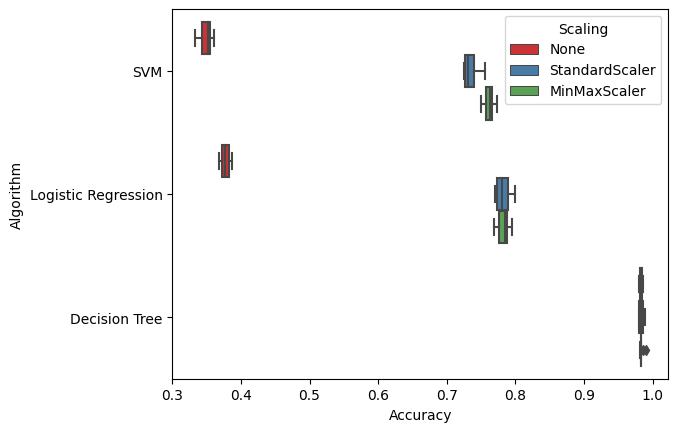

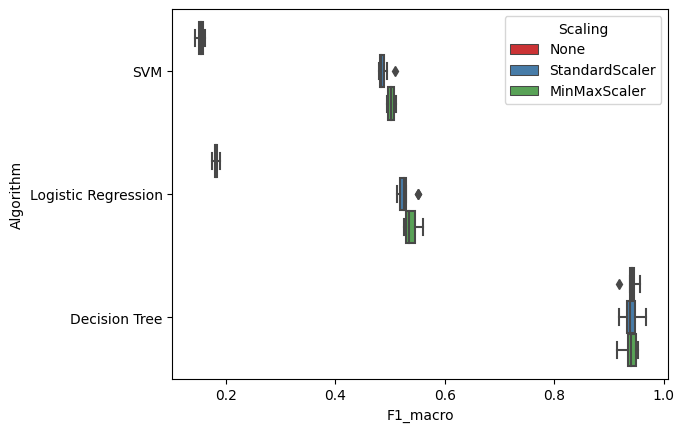

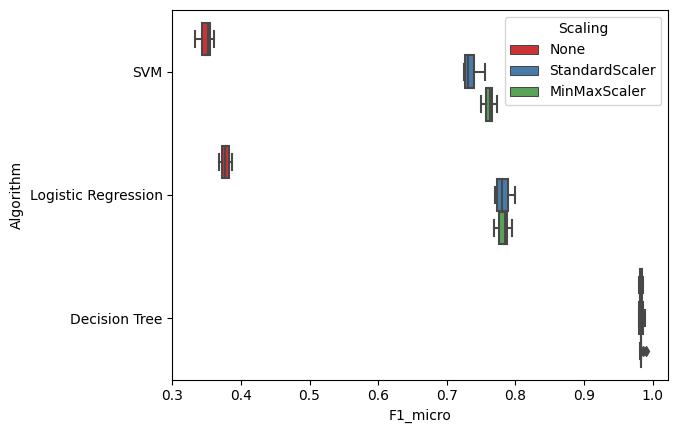

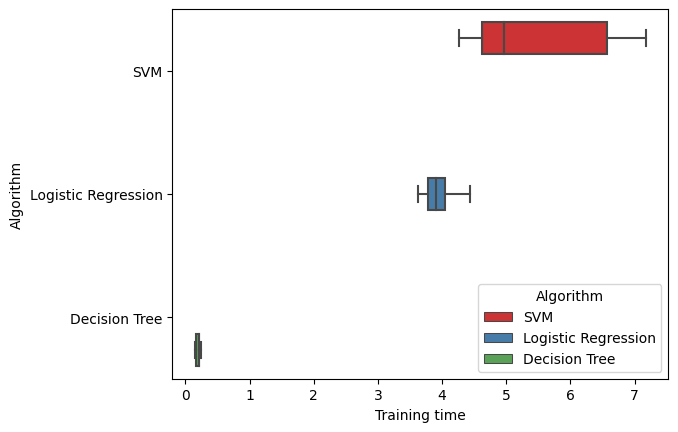

In [60]:
sns.boxplot(y="Algorithm", x="Accuracy",
            hue="Scaling", palette=sns_palette,
            data=res)
plt.show()
sns.boxplot(y="Algorithm", x="F1_macro",
            hue="Scaling", palette=sns_palette,
            data=res)
plt.show()
sns.boxplot(y="Algorithm", x="F1_micro",
            hue="Scaling", palette=sns_palette,
            data=res)
plt.show()
sns.boxplot(y="Algorithm", x="Training time",
            hue="Algorithm", palette=sns_palette,
            data=res)
plt.show()

### 5 fold Cross-validation with and without scaling

In [61]:
def cross_validation(model_label, model, X, y, scale=None):

    # if a scaling method is given, perform scaling
    if scale is not None:
        model = make_pipeline(scale, model)

    # dataframe for results for each fold
    results = pd.DataFrame(columns=['Fold', 'Algorithm', 'Scaling', 'F1_macro', 'F1_micro', 'Accuracy', 'Training time'])


    cval = cross_validate(model, X, y, scoring={'F1_macro':'f1_macro',
                                                'F1_micro':'f1_micro',
                                                'accuracy': 'accuracy' 
                                               }, 
                         n_jobs=-1)
    
    for i in range(len(cval['test_accuracy'])):
     # fetch calculated metrics
        f1_macro = cval['test_F1_macro'][i]
        f1_micro = cval['test_F1_micro'][i]
        acc = cval['test_accuracy'][i]
        tr_time = cval['fit_time'][i]

        result =   {'Fold': i+1,
                    'Algorithm': model_label, 
                   'Scaling': 'None' if scale is None else type(scale).__name__,
                    'F1_macro': f1_macro,
                    'F1_micro': f1_micro,
                   'Accuracy': acc,
                    'Training time': tr_time}
        results.loc[len(results)] = result # type: ignore
    
    return results

In [62]:
res = pd.DataFrame(columns=['Fold', 'Algorithm', 'Scaling', 'F1_macro', 'F1_micro', 'Accuracy', 'Training time'])

res =  pd.concat([res, cross_validation("SVM", SVC(), X, y)])
res =  pd.concat([res, cross_validation("SVM", SVC(), X, y, scale=StandardScaler())])
res =  pd.concat([res, cross_validation("SVM", SVC(), X, y, scale=MinMaxScaler())])

res = pd.concat([res, cross_validation("Logistic Regression", LogisticRegression(solver='saga'), X, y)])
res = pd.concat([res, cross_validation("Logistic Regression", LogisticRegression(solver='saga'), X, y, scale=StandardScaler())])
res = pd.concat([res, cross_validation("Logistic Regression", LogisticRegression(solver='saga'), X, y, scale=MinMaxScaler())])

res = pd.concat([res, cross_validation("Decision Tree", DecisionTreeClassifier(), X, y)])
res = pd.concat([res, cross_validation("Decision Tree", DecisionTreeClassifier(), X, y, scale=StandardScaler())])
res = pd.concat([res, cross_validation("Decision Tree", DecisionTreeClassifier(), X, y, scale=MinMaxScaler())])
res

,Fold,Algorithm,Scaling,F1_macro,F1_micro,Accuracy,Training time
0,1,SVM,None,0.161085,0.3540,0.3540,23.896051
1,2,SVM,None,0.153528,0.3470,0.3470,23.990794
2,3,SVM,None,0.149090,0.3400,0.3400,23.855161
3,4,SVM,None,0.149026,0.3300,0.3300,23.917992
4,5,SVM,None,0.158781,0.3680,0.3680,23.868127
0,1,SVM,StandardScaler,0.494511,0.7475,0.7475,16.773721
1,2,SVM,StandardScaler,0.490905,0.7370,0.7370,16.697920
2,3,SVM,StandardScaler,0.497861,0.7385,0.7385,16.882423
3,4,SVM,StandardScaler,0.492645,0.7435,0.7435,16.872450
4,5,SVM,StandardScaler,0.489892,0.7415,0.7415,16.908354


In [63]:
res.groupby(['Algorithm', 'Scaling']).agg({'Accuracy': [ 'min', 'mean', 'max', 'std']})

Accuracy                          
                                        min    mean     max       std
Algorithm           Scaling                                          
Decision Tree       MinMaxScaler     0.9845  0.9857  0.9880  0.001440
                    None             0.9825  0.9863  0.9890  0.002706
                    StandardScaler   0.9845  0.9862  0.9880  0.001255
Logistic Regression MinMaxScaler     0.7875  0.7907  0.7970  0.003735
                    None             0.3545  0.3774  0.3850  0.013079
                    StandardScaler   0.7725  0.7845  0.7945  0.008070
SVM                 MinMaxScaler     0.7620  0.7688  0.7760  0.005322
                    None             0.3300  0.3478  0.3680  0.014360
                    StandardScaler   0.7370  0.7416  0.7475  0.004159

In [64]:
res.groupby(['Algorithm', 'Scaling']).agg({'F1_macro': [ 'min', 'mean', 'max', 'std']})

F1_macro                              
                                         min      mean       max       std
Algorithm           Scaling                                               
Decision Tree       MinMaxScaler    0.932566  0.946081  0.962632  0.013634
                    None            0.929314  0.948074  0.961808  0.012998
                    StandardScaler  0.930735  0.945961  0.965040  0.014200
Logistic Regression MinMaxScaler    0.536840  0.550292  0.569424  0.015638
                    None            0.172755  0.182832  0.186429  0.005689
                    StandardScaler  0.522750  0.528178  0.536240  0.005796
SVM                 MinMaxScaler    0.502459  0.510628  0.516353  0.005223
                    None            0.149026  0.154302  0.161085  0.005515
                    StandardScaler  0.489892  0.493163  0.497861  0.003160

In [65]:
res.groupby(['Algorithm', 'Scaling']).agg({'F1_micro': [ 'min', 'mean', 'max', 'std']})

F1_micro                          
                                        min    mean     max       std
Algorithm           Scaling                                          
Decision Tree       MinMaxScaler     0.9845  0.9857  0.9880  0.001440
                    None             0.9825  0.9863  0.9890  0.002706
                    StandardScaler   0.9845  0.9862  0.9880  0.001255
Logistic Regression MinMaxScaler     0.7875  0.7907  0.7970  0.003735
                    None             0.3545  0.3774  0.3850  0.013079
                    StandardScaler   0.7725  0.7845  0.7945  0.008070
SVM                 MinMaxScaler     0.7620  0.7688  0.7760  0.005322
                    None             0.3300  0.3478  0.3680  0.014360
                    StandardScaler   0.7370  0.7416  0.7475  0.004159

#### plot the results

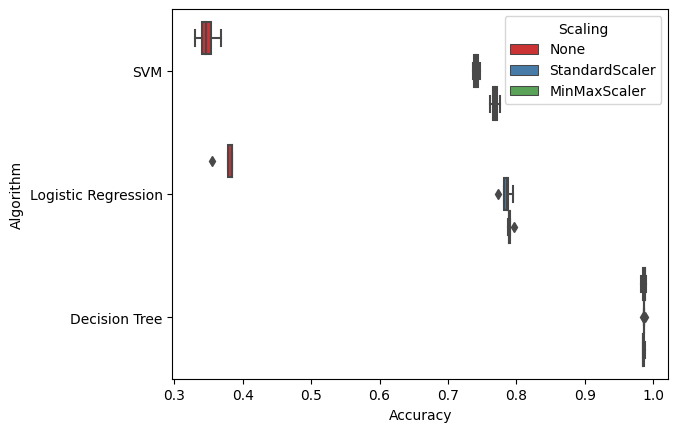

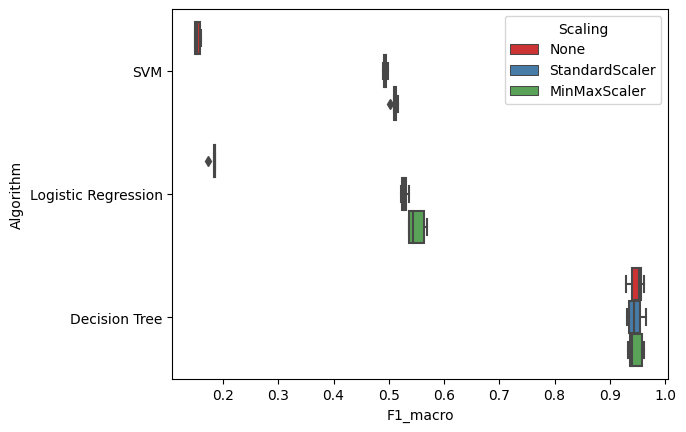

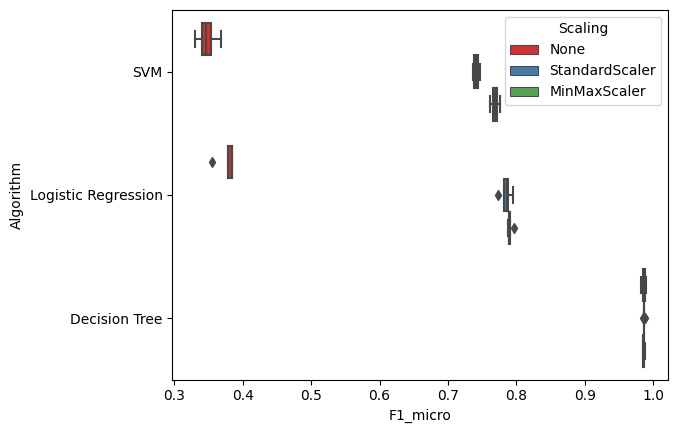

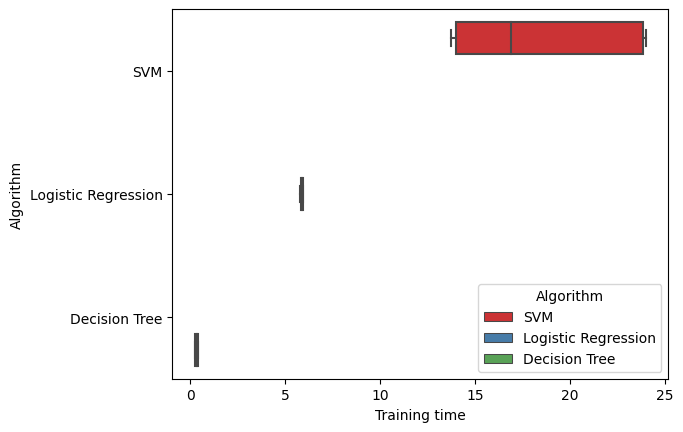

In [66]:
sns.boxplot(y="Algorithm", x="Accuracy",
            hue="Scaling", palette=sns_palette,
            data=res)
plt.show()
sns.boxplot(y="Algorithm", x="F1_macro",
            hue="Scaling", palette=sns_palette,
            data=res)
plt.show()
sns.boxplot(y="Algorithm", x="F1_micro",
            hue="Scaling", palette=sns_palette,
            data=res)
plt.show()
sns.boxplot(y="Algorithm", x="Training time",
            hue="Algorithm", palette=sns_palette,
            data=res)
plt.show()

# Fine tune model for the best 3 algos: decision tree, logistic regression, svm

In [64]:
sclr = StandardScaler()
X_s = sclr.fit_transform(X)


In [74]:
from sklearn.preprocessing import MinMaxScaler
sclr_minmax = MinMaxScaler()
X_mm = sclr_minmax.fit_transform(X)

### Decision tree

In [59]:
dt = DecisionTreeClassifier()

#### Hyperparameters - improves performance a little

In [60]:
# Define the parameter grid to search
# middle number is best option as found through stepwise comparison
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 15, 20, 30],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [5, 6, 7]
}

scoring = ['f1_macro', 'f1_micro', 'accuracy' ]
best_params = {}

for metric in scoring:
    grid_search = GridSearchCV(dt, param_grid=param_grid, cv=5, scoring=metric, refit=False)
    grid_search.fit(X_s, y)
    print(f"Best parameters for {metric}: {grid_search.best_params_}")
    print(f"Best score for {metric}: {grid_search.best_score_}")
    best_params[metric] = {'params': grid_search.best_params_, 'score': grid_search.best_score_}

joblib.dump(best_params, 'best_params.pkl')


Best parameters for recall_macro: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score for recall_macro: 0.9580086091215543
Best parameters for f1_macro: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best score for f1_macro: 0.9554332391609327
Best parameters for accuracy: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best score for accuracy: 0.9890000000000001


['best_params.pkl']

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Define the parameter grid for model selection using GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform model selection using GridSearchCV with cross-validation on the training set
clf = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
clf.fit(X_train, y_train)

# Evaluate the best model on the validation set
y_pred = clf.predict(X_val)
val_f1 = f1_score(y_val, y_pred, average='macro')
val_acc = accuracy_score(y_val, y_pred)

# Train the best model on the combined training and validation sets
best_model = clf.best_estimator_
best_model.fit(X_train_val, y_train_val)

# Evaluate the final model on the test set
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred, average='macro')
test_acc = accuracy_score(y_test, y_pred)

print("Validation F1 score:", val_f1)
print("Validation accuracy:", val_acc)
print("Test F1 score:", test_f1)
print("Test accuracy:", test_acc)


#### Recursive Feature Elimination - improves performance

In [61]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit decision tree model on training set
dt.fit(X_train, y_train)

# Evaluate performance on testing set
y_pred = dt.predict(X_test)
print('F1_macro:', f1_score(y_test, y_pred, average='macro'))
print('F1_micro:', f1_score(y_test, y_pred, average='micro'))
print('Accuracy:', accuracy_score(y_test, y_pred))

# Use RFE to select optimal features
rfe = RFE(estimator=dt, n_features_to_select=5, step=1)
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X.columns[rfe.support_]

# Fit decision tree model on selected features
dt.fit(X_train[selected_features], y_train)

# Evaluate performance on testing set with selected features
y_pred = dt.predict(X_test[selected_features])
print('F1_macro with selected features:', f1_score(y_test, y_pred, average='macro'))
print('F1_micro score with selected features:', f1_score(y_test, y_pred, average='micro'))
print('Accuracy with selected features:', accuracy_score(y_test, y_pred))




Recall: 0.9885
F1 score: 0.9886167113866589
Accuracy: 0.9885
Recall with selected features: 0.991
F1 score with selected features: 0.9909482044304846
Accuracy with selected features: 0.991


#### Tree-based feature selection - improves performance

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.values
X_test = X_test.values

dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_mirco = f1_score(y_test, y_pred, average='micro')

print('F1 macro before feature selection:', f1_macro)
print('F1 micro score before feature selection:', f1_micro)
print('Accuracy before feature selection:', accuracy)

selector = SelectFromModel(dt, prefit=True, threshold='mean')
X_train_new = selector.transform(X_train)

# Train a new decision tree classifier using the selected features
dt_new = DecisionTreeClassifier(random_state=42)
dt_new.fit(X_train_new, y_train)

# Apply the same feature selection to the testing set
X_test_new = selector.transform(X_test)

# Evaluate the performance of the new classifier on the testing set
y_pred_new = dt_new.predict(X_test_new)
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_macro_new = f1_score(y_test, y_pred_new, average='macro')
f1_micro_new = f1_score(y_test, y_pred_new, average='micro')

print('F1 macro on the testing set after feature selection:', f1_macro_new)
print('F1 micro score on the testing set after feature selection:', f1_micro_new)
print('Accuracy on the testing set after feature selection:', accuracy_new)



Recall before feature selection: 0.982
F1 score before feature selection: 0.9819541234203191
Accuracy before feature selection: 0.982
Recall on the testing set after feature selection: 0.9955
F1 score on the testing set after feature selection: 0.9955125408521068
Accuracy on the testing set after feature selection: 0.9955


#### Regularization with L1 - no change

In [63]:
# Apply L1 regularization to select important features
selector = SelectFromModel(dt, prefit=True, threshold='mean', norm_order=1)

# Transform the training and testing data to include only the selected features
X_train_new = selector.transform(X_train)
X_test_new = selector.transform(X_test)

# Train a new decision tree classifier using the selected features
dt_new = DecisionTreeClassifier(random_state=42)
dt_new.fit(X_train_new, y_train)

# Evaluate the performance of the new classifier on the testing set
y_pred_new = dt_new.predict(X_test_new)
accuracy_new = accuracy_score(y_test, y_pred_new)
f1_macro_new = f1_score(y_test, y_pred_new, average='macro')
f1_micro_new = f1_score(y_test, y_pred_new, average='micro')

print('F1 macro on the testing set after L1 regularization:', f1_macro_new)
print('F1 micro score on the testing set after L1 regularization:', f1_micro_new)
print('Accuracy on the testing set after L1 regularization:', accuracy_new)

Recall on the testing set after L1 regularization: 0.9955
F1 score on the testing set after L1 regularization: 0.9955125408521068
Accuracy on the testing set after L1 regularization: 0.9955


#### Regularization with L2 - todo compare with above (slightly worse than l1, quite similar to nothing having been done)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a decision tree classifier with L2 regularization
dt_L2 = DecisionTreeClassifier(random_state=42, min_samples_leaf=2)

# Train the classifier on the training data
dt_L2.fit(X_train, y_train)

# Evaluate the performance of the classifier on the testing data
y_pred = dt_L2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

print('F1 macro with L2 regularization:', f1_macro)
print('F1 micro score with L2 regularization:', f1_micro)
print('Accuracy with L2 regularization:', accuracy)

Recall with L2 regularization: 0.9835
F1 score with L2 regularization: 0.9835137757133142
Accuracy with L2 regularization: 0.9835


#### Principal Component Analysis (PCA) - reduces performance as is rn, play with test size

In [65]:
# Split the data into training and testing sets
#use normalized x_s
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2, random_state=42)

dt.fit(X_train, y_train)
y_pred_orig = dt.predict(X_test)
accuracy_orig = accuracy_score(y_test, y_pred_orig)
f1_macro_orig = f1_score(y_test, y_pred_orig, average='macro')
f1_micro_orig = f1_score(y_test, y_pred_orig, average='micro')
print('F1 macro without PCA:', f1_macro_orig)
print('F1 micro score without PCA:', f1_micro_orig)
print('Accuracy without PCA:', accuracy_orig)


# Apply PCA
pca = PCA(n_components=0.7)  # keep enough components to explain n_comp*100% of the variance
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Train a decision tree classifier on the transformed data
dt.fit(X_train_pca, y_train)

#evaluate
y_pred = dt.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
print('F1 macro with pca:', f1_macro)
print('F1 micro with pca:', f1_micro)
print('Accuracy with pca:', accuracy)

Recall without PCA: 0.9845
F1 score without PCA: 0.9844577420551784
Accuracy without PCA: 0.9845
Recall with pca: 0.36
F1 with pca: 0.3594233894931471
Accuracy with pca: 0.36


### Logistic regression

#### solvers (TODO: increase iteration nrs for sag, lbfgs)

In [1]:
solvers = ['newton-cg', 'liblinear']
# ['sag', 'saga', lbfgs]
# Loop over the solvers and compute their performance using cross-validation
for solver in solvers:
    lr = LogisticRegression(solver=solver, max_iter = 20000) # type: ignore
    scoring = ['f1_macro', 'f1_micro' 'accuracy']
    results = cross_validate(lr, X_s, y, scoring=scoring, cv=5)

    print(f"Solver: {solver}")
    print(f"F1 macro: {results['test_f1_macro'].mean():.3f}")
    print(f"F1 micro: {results['test_f1_micro'].mean():.3f}")
    print(f"Accuracy: {results['test_accuracy'].mean():.3f}")
   
    print("")

# only newton-cg, liblinear converged, newton-cg scored better overall

NameError: name 'LogisticRegression' is not defined

#### penalty type

##### L1 - slight improvement

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2)

# Train and test logistic regression without regularization
lr_no_reg = LogisticRegression(solver='liblinear')
lr_no_reg.fit(X_train, y_train)
y_pred_no_reg = lr_no_reg.predict(X_test)

# Evaluate performance without regularization
print("Metrics without regularization:")
print("F1 macro:", f1_score(y_test, y_pred_no_reg, average='macro'))
print("F1 micro:", f1_score(y_test, y_pred_no_reg, average='micro'))
print("Accuracy:", accuracy_score(y_test, y_pred_no_reg))

# Train and test logistic regression with L1 regularization
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear')
lr_l1.fit(X_train, y_train)
y_pred_l1 = lr_l1.predict(X_test)



# Evaluate performance with L1 regularization
print("Metrics with L1 regularization:")
print("F1 macro:", f1_score(y_test, y_pred_l1, average='macro'))
print("F1 score:", f1_score(y_test, y_pred_l1, average='micro'))
print("Accuracy:", accuracy_score(y_test, y_pred_l1))

Metrics without regularization:
Recall: 0.67
F1 score: 0.648236121222819
Accuracy: 0.67
Metrics with L1 regularization:
Recall: 0.678
F1 score: 0.6570618997771726
Accuracy: 0.678


In [68]:
##maybe look at newton too

##### L2 - no change

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2)
# Train and test logistic regression without regularization
lr_no_reg = LogisticRegression(solver='liblinear')
lr_no_reg.fit(X_train, y_train)
y_pred_no_reg = lr_no_reg.predict(X_test)

# Evaluate performance without regularization
print("Metrics without regularization:")
print("F1 macro:", f1_score(y_test, y_pred_no_reg, average='macro'))
print("F1 score:", f1_score(y_test, y_pred_no_reg, average='micro'))
print("Accuracy:", accuracy_score(y_test, y_pred_no_reg))

# Train and test logistic regression with L2 regularization
lr_l2 = LogisticRegression(penalty='l2', solver='liblinear')
lr_l2.fit(X_train, y_train)
y_pred_l2 = lr_l2.predict(X_test)

# Evaluate performance with L2 regularization
print("Metrics with L2 regularization:")
print("F1 macro:", f1_score(y_test, y_pred_l2, average='macro'))
print("F1 micro score:", f1_score(y_test, y_pred_l2, average='micro'))
print("Accuracy:", accuracy_score(y_test, y_pred_l2))

Metrics without regularization:
Recall: 0.6725
F1 score: 0.6520561492292826
Accuracy: 0.6725
Metrics with L2 regularization:
Recall: 0.6725
F1 score: 0.6520561492292826
Accuracy: 0.6725


#### Class Weight- slightly worse

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.2)

# Define the logistic regression model
lr = LogisticRegression(solver='liblinear')

# Define the parameters to search over
param_grid = {'class_weight': ['balanced', None]}
#scoring
metric = ['f1_macro', 'f1_micro', 'accuracy' ]

for metric in metric:
    grid_search = GridSearchCV(lr, param_grid=param_grid, cv=5, scoring=metric, refit=False)
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and their corresponding score for the current metric
    print("Best parameters for {}: {}".format(metric, grid_search.best_params_))
    print("Best score for {}: {:.4f}".format(metric, grid_search.best_score_))


Best parameters for recall_macro: {'class_weight': 'balanced'}
Best score for recall_macro: 0.5251
Best parameters for f1_macro: {'class_weight': 'balanced'}
Best score for f1_macro: 0.5192
Best parameters for accuracy: {'class_weight': 'balanced'}
Best score for accuracy: 0.6790


### SVM

Hyperparameter tuning - improvement

In [72]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.3, random_state=42)

# Define the SVM model
svm_model = svm.SVC(kernel='rbf', decision_function_shape='ovr')

svm_model.fit(X_train, y_train)
# Evaluate the performance of the model before parameter tuning
y_pred = svm_model.predict(X_test)
print("Performance of the model before parameter tuning:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 macro:", f1_score(y_test, y_pred, average='macro'))
print("F1 micro:", f1_score(y_test, y_pred, average='micro'))

# Set the parameters to be searched by grid search
param_grid = {'C': [30, 35, 40,], 'gamma': [0.0001, 0.001, 0.01]}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters found by grid search:")
print(grid_search.best_params_)

# Train the SVM model with the best parameters
svm_model_best = svm.SVC(kernel='rbf', decision_function_shape='ovr', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
svm_model_best.fit(X_train, y_train)

# Evaluate the performance of the model after parameter tuning
y_pred = svm_model_best.predict(X_test)
print("Performance of the model after parameter tuning:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 macro:", f1_score(y_test, y_pred, average='macro'))
print("F1 micro:", f1_score(y_test, y_pred, average='micro'))



Performance of the model before parameter tuning:
Accuracy: 0.7173333333333334
F1 macro: 0.47842502122496217
F1 micro: 0.7173333333333334
Best parameters found by grid search:
{'C': 35, 'gamma': 0.001}
Performance of the model after parameter tuning:
Accuracy: 0.846
F1 macro: 0.7138366403287039
F1 micro: 0.8459999999999999


In [86]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mm, y, test_size=0.3, random_state=42)

# Define the SVM model
svm_model = svm.SVC(kernel='rbf', decision_function_shape='ovr')

svm_model.fit(X_train, y_train)
# Evaluate the performance of the model before parameter tuning
y_pred = svm_model.predict(X_test)
print("Performance of the model before parameter tuning:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 macro:", f1_score(y_test, y_pred, average='macro'))
print("F1 micro:", f1_score(y_test, y_pred, average='micro'))

# Set the parameters to be searched by grid search
param_grid = {'C': [90, 100, 110], 'gamma': [0.01, 0.1, 1]}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters found by grid search:")
print(grid_search.best_params_)

# Train the SVM model with the best parameters
svm_model_best = svm.SVC(kernel='rbf', decision_function_shape='ovr', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
svm_model_best.fit(X_train, y_train)

# Evaluate the performance of the model after parameter tuning
y_pred = svm_model_best.predict(X_test)
print("Performance of the model after parameter tuning:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 macro:", f1_score(y_test, y_pred, average='macro'))
print("F1 micro:", f1_score(y_test, y_pred, average='micro'))



Performance of the model before parameter tuning:
Accuracy: 0.7496666666666667
F1 macro: 0.48868880508216145
F1 micro: 0.7496666666666667
Best parameters found by grid search:
{'C': 100, 'gamma': 0.01}
Performance of the model after parameter tuning:
Accuracy: 0.867
F1 macro: 0.7105952658312259
F1 micro: 0.867
